## Import

In [251]:
import seaborn as sns;
import pandas as pd;
import numpy as np;
import seaborn as sns;
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as TTS
from sklearn.ensemble import GradientBoostingClassifier

# pipeline elements
from sklearn.decomposition import PCA # PCA = Principal Component Analysis
from sklearn.neighbors import KNeighborsClassifier as KNN 

# pipeline materiaux
from sklearn.pipeline import Pipeline # PCA = Principal Component Analysis
from sklearn.model_selection import GridSearchCV

## Collecte de données

In [252]:
# charger le dataset
ibm = pd.read_csv('../../data/IBM_HR_ATTRITION.csv')

## Feature Engineer

In [253]:
# On va traiter les élements qui ne sont ni des float ni des int (en l'occurence les object et strings)

ibm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [254]:
ibm = ibm.drop(['OverTime','Over18','MaritalStatus','JobRole','EducationField','Department','BusinessTravel'],axis=1)
attrition = {'Yes': 1, 'No': 0} #On defini les noms des variables qui vont être transformer en bolean
ibm['Attrition'] = ibm['Attrition'].map(attrition) #On cast la colonne de notre tableau
gender = {'Female': 1, 'Male': 0} #On defini les noms des variables qui vont être transformer en bolean
ibm['Gender'] = ibm['Gender'].map(gender) #On cast la colonne de notre tableau
ibm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Age                       1470 non-null   int64
 1   Attrition                 1470 non-null   int64
 2   DailyRate                 1470 non-null   int64
 3   DistanceFromHome          1470 non-null   int64
 4   Education                 1470 non-null   int64
 5   EmployeeCount             1470 non-null   int64
 6   EmployeeNumber            1470 non-null   int64
 7   EnvironmentSatisfaction   1470 non-null   int64
 8   Gender                    1470 non-null   int64
 9   HourlyRate                1470 non-null   int64
 10  JobInvolvement            1470 non-null   int64
 11  JobLevel                  1470 non-null   int64
 12  JobSatisfaction           1470 non-null   int64
 13  MonthlyIncome             1470 non-null   int64
 14  MonthlyRate               1470 non-null 

In [255]:
Y = ibm['Attrition'].astype('category').cat.codes # On veut afficher le type de fleur
X = ibm.drop('Attrition', axis='columns') # On garde que les dimension de la fleur

## Entrainer le model

In [256]:
X_tr, X_te, Y_tr, Y_te = TTS(X, Y,              # features, target
                            stratify = Y,       # Va prendre une proportion aux hasard de valeurs différentes histoire de ne pas avoir des cas où l'on a que des même valeur
                            random_state=777,   # Sert à fixer le harsard pour ne pas avoir des résultat différents à chaque tests.
                            train_size=0.8)     # 50% de X_train et Y_train et 50% de Y_test et Y_test

In [257]:
for each in [X_tr, X_te, Y_tr, Y_te]:
    print(each.shape)

(1176, 27)
(294, 27)
(1176,)
(294,)


In [258]:
# Créer la pipeline
#
# Enssemble d'algorithme compliqué
# Param: Algo pca, permet de connaitre la valeur d'accuracy d'une valeur
#              d'un point, il va tester les colonne 1 par 1 afin de savoir
#              quelles sont les colonnes qui on le plus d'accuracy pour définir les colonnes 
#              les plus utile afin de diminué le nombre de features et donc d'augmenter 
#              les performances de calculs
#        Algo knn, de l'anglais k-nearest neighbors.
#              Pour estimer la sortie associée à une nouvelle entrée x, 
#              la méthode des k plus proches voisins consiste à prendre en compte (de façon identique) 
#              les k échantillons d'apprentissage dont l’entrée est la plus proche de la nouvelle entrée x,
#              selon une distance à définir.

pipeline_details = [('pca', PCA()),      # Algo de dimension reduction
                  ('knn', KNN())]        # Algo de machine learning 

In [259]:
pipeline = Pipeline(pipeline_details)

In [260]:
pipeline

Pipeline(steps=[('pca', PCA()), ('knn', KNeighborsClassifier())])

In [261]:
# Paramètrer la Grid Search
hyperparameters = {}
hyperparameters['pca__n_components'] = list(range(1, 10+1, 1)) # Il va faire des test de 1 à 64 avec un pas de 3. Il s'agit de la liste des variable qui sera stocker dans n_component. Celle qui aura le meilleurs résultat sera testé.
hyperparameters['knn__n_neighbors'] = [1, 2, 3, 9, 21]         # Il va chercher avec 1 voisin jusqu'a 21 et celui qui aura la meilleurs accuracy sera selectionner

hyperparameters

{'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'knn__n_neighbors': [1, 2, 3, 9, 21]}

In [262]:
# Créer la grid search

hyperparameter_search = GridSearchCV(pipeline,            # Notre pipeline
                                    hyperparameters,      # Notre hyperparametre
                                    scoring='accuracy',   # Ce qui nous interesse, c'est l'accuracy
                                    cv=5)                 # cv est le nombre de model utilisé

In [263]:
hyperparameter_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 9, 21],
                         'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='accuracy')

In [264]:
hyperparameter_search.fit(X_tr, Y_tr)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 9, 21],
                         'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='accuracy')

In [265]:
hyperparameter_search.best_score_

0.838434908041832

In [266]:
hyperparameter_search.best_params_

{'knn__n_neighbors': 21, 'pca__n_components': 1}

In [267]:
pca = PCA(n_components=10)
knn = KNN(n_neighbors=3)

In [268]:
pca.fit(X_tr)

PCA(n_components=10)

In [269]:
X_tr_PCA = pca.transform(X_tr)  # On utilise en général le pca.transform pour optimiser avant le fit
X_te_PCA = pca.transform(X_te)

knn.fit(X_tr_PCA, Y_tr)
predictions = knn.predict(X_te_PCA) # On veut faire une prédiction par rapport à notre X_te_PCA

In [270]:
# On chercher à prédir X_te_PCA par rapport à Y_te

accuracy = lambda p,y: (p==y).sum()/p.shape[0] # Notre fonction de précision
"TEST ACCURACY: ", accuracy(predictions, Y_te)

('TEST ACCURACY: ', 0.7891156462585034)

In [271]:
# On cherche à prédir X_tr_PCA par rapport à Y_tr

train_preds = knn.predict(X_tr_PCA)
"TRAIN ACCURACY: ", accuracy(train_preds, Y_tr)

('TRAIN ACCURACY: ', 0.8758503401360545)

## Confusion matrix

In [272]:
(train_preds, Y_tr)
(predictions, Y_te)

from sklearn.metrics import confusion_matrix

labels = range(2)                                             # Equivaut aux valeurs que peut retourner la target
cm_train = confusion_matrix(train_preds, Y_tr, labels=labels)
cm_test = confusion_matrix(predictions, Y_te, labels=labels)

In [273]:
Y.unique()

array([1, 0], dtype=int8)

In [274]:
labels

range(0, 2)

In [275]:
def show_cm(cm, labels):
    df_cm = pd.DataFrame(cm, labels, labels)
    sns.heatmap(df_cm, annot=True)
    plt.show()

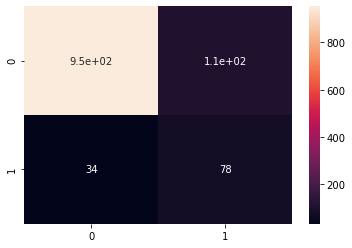

In [276]:
show_cm(cm_train, labels)

In [277]:
cm_train

array([[952, 112],
       [ 34,  78]], dtype=int64)

In [278]:
cm_test

array([[227,  42],
       [ 20,   5]], dtype=int64)

In [279]:
def show_cm(cm, labels):
  df_cm = pd.DataFrame(cm,labels, labels)
  sns.heatmap(df_cm, annot=True)
  plt.show()

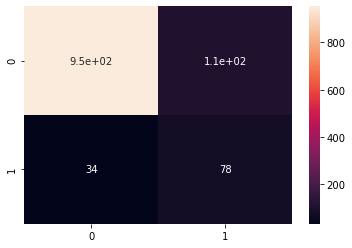

In [280]:
show_cm(cm_train, labels)

In [281]:
# On souhaite retrouvé nos résultat de départ

950 + 110 + 34 +78

1172

In [282]:
# On regarde le score obtenu

1172 / (110 + 34)

8.13888888888889

In [283]:
# On regarde si l'on a retrouver le poucentage obtenu lors de l'accuracy

(950 + 78) / 1172

0.8771331058020477